In [59]:
#oddball課題のためにFullrandomにした刺激の種類をテキストに保存しているので
#それを読み込み，表示

with open(r'C:\Users\Hokud\OneDrive\ドキュメント\Python Scripts\20240511\File6.txt', 'r') as file:
    contents = file.read()
    
print(contents)

Stop to output sound
Start to output
Device number: Dev1
Channel Mode: Sound = ao0, Trigger = Port0, ExDevice = ao2 AllTrigger = ao1
Trigger Level: 3.5 Function Generator Trigger Level: 4.5

Output Sound!
Name: p0
Type: Pure

Output Sound!
Name: p2
Type: Pure

Output Sound!
Name: p3
Type: Pure

Output Sound!
Name: p1
Type: Pure

Output Sound!
Name: p5
Type: Pure

Output Sound!
Name: p4
Type: Pure

Output Sound!
Name: p5
Type: Pure

Output Sound!
Name: p0
Type: Pure

Output Sound!
Name: p2
Type: Pure

Output Sound!
Name: p1
Type: Pure

Output Sound!
Name: p4
Type: Pure

Output Sound!
Name: p3
Type: Pure

Output Sound!
Name: p5
Type: Pure

Output Sound!
Name: p0
Type: Pure

Output Sound!
Name: p2
Type: Pure

Output Sound!
Name: p3
Type: Pure

Output Sound!
Name: p1
Type: Pure

Output Sound!
Name: p4
Type: Pure

Output Sound!
Name: p0
Type: Pure

Output Sound!
Name: p2
Type: Pure

Output Sound!
Name: p1
Type: Pure

Output Sound!
Name: p3
Type: Pure

Output Sound!
Name: p4
Type: Pure

Outp

In [60]:
#上記で読み込んだテキストには，p+'No.'以外の不必要な文字列が含まれている．p+'No.'の部分のみを抜き出して表示
import re
import pandas as pd

# Extract the strings matching the pattern "p+'No.'"
pattern = r"p\d+"
matches = re.findall(pattern, contents)

# Create a dataframe with the extracted strings
df = pd.DataFrame(matches, columns=['Name'])

print(df)

#p+'No.'を簡単に抜き出し，その番号を記載
order_p5 = df[df['Name'] == 'p5'].index.tolist()
print(order_p5)

    Name
0     p0
1     p2
2     p3
3     p1
4     p5
..   ...
295   p5
296   p0
297   p4
298   p1
299   p3

[300 rows x 1 columns]
[4, 6, 12, 23, 28, 34, 36, 45, 53, 59, 61, 71, 76, 82, 86, 94, 100, 106, 109, 118, 123, 126, 134, 142, 145, 151, 159, 167, 170, 175, 182, 187, 194, 203, 208, 212, 220, 223, 228, 234, 245, 251, 257, 258, 267, 273, 281, 283, 289, 295]


In [61]:
len(order_p5)

50

In [62]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import signal
from scipy import interpolate
from scipy import hanning, hamming, histogram, log10
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from matplotlib.patches import Rectangle
import seaborn as sns
import math
import pywt
from swan import pycwt
from pathlib import Path

mat = scipy.io.loadmat('File6.mat')

def lowpass(time, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2                              # ナイキスト周波数
    wp = fp / fn                                     # ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn                                     # ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)     # オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "low")               # フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, time)                  # 信号に対してフィルタをかける
    return y 

In [63]:
len(mat['EVT01'])

300

In [70]:
#パラメータ変更
root = Path(r"C:\Users\Hokud\OneDrive\ドキュメント\Python Scripts\20240511\File6mat")

fp = 50                                              # 通過域端周波数[Hz]
fs = 100                                             # 阻止域端周波数[Hz]
gpass = 3                                            # 通過域端最大損失[dB]
gstop = 20                                           # 阻止域端最小損失[dB]

fs1 = samplerate = 40000
base_left = -0.2
base_right = 0
analy_lenbase = 8000
time_base = np.arange(base_left,base_right,1/fs1)
cut_left = -0.2
cut_right = 0.7
analy_len = 36000
time = np.arange(cut_left,cut_right,1/fs1)
stimuli = 0                                          # 刺激の種類変更（0～4：Click, 2, 4, 8, 16）

WB = 'WB'
Ch = 'Ch'
name = 'ampsum_leave'
plt.rcParams["font.size"] = 14

#------------------------------------------------------------------------------------------------------------------
lag_base = mat['WB03_ts']
lagsample_base = int(lag_base * fs1)

mat_data = mat['EVT01']

# 余りが5でないとき，つまり標準刺激
#sttime_base = mat_data[np.arange(len(mat_data)) % 6 != 5] + base_left 
# 余りが5のとき，つまり逸脱刺激
#sttime_base = mat_data[np.arange(len(mat_data)) % 6 == 5] + base_left 

# 指定の要素,個別に指定する場合
#selected_indices = [3, 8, 12, 21, 25, 33, 38, 44, 51, 59, 65, 67, 72, 79, 84, 93, 101, 105,
#                  110, 115, 123, 128, 136, 139, 145, 154, 161, 166, 169, 174, 184, 188, 195, 198, 207, 212, 216, 225, 231, 239, 244, 246, 253, 
#                  261, 266, 270, 276, 287, 293, 297]

#上のセルで既に取り出した要素番号を指定する場合
selected_indices = order_p5

# 指定の要素以外を取り出す
#sttime_base = mat_data[np.logical_not(np.isin(np.arange(len(mat_data)), selected_indices))] + base_left
# 指定の要素を取り出す
sttime_base = mat_data[selected_indices] + base_left

lists_st_base = [] 
for sm in sttime_base:
    stsample_base = int(sm * fs1 - lagsample_base)
    lists_st_base.append(stsample_base) 

# 余りが5でないとき，つまり標準刺激
#edtime_base = mat_data[np.arange(len(mat_data)) % 6 != 5] + base_right 
# 余りが5のとき，つまり逸脱刺激
#edtime_base = mat_data[np.arange(len(mat_data)) % 6 == 5] + base_right 

# 指定の要素以外を取り出す
#edtime_base = mat_data[np.logical_not(np.isin(np.arange(len(mat_data)), selected_indices))] + base_right
# 指定の要素を取り出す
edtime_base = mat_data[selected_indices] + base_right

lists_ed_base = []
for sm2 in edtime_base:
    edsample_base = int(sm2 * fs1 - lagsample_base)
    lists_ed_base.append(edsample_base)

amp_sum_base = []
amp_del_base = [] #数が合わない用

ampsum_baseleave1 = [] #残す用
ampsum_baseleave2 = []
ampsum_baseleave3 = []
ampsum_baseleave4 = []
ampsum_baseleave5 = []
ampsum_baseleave6 = []
ampsum_baseleave7 = []
ampsum_baseleave8 = []
ampsum_baseleave9 = []
ampsum_baseleave10 = []
ampsum_baseleave11 = []
ampsum_baseleave12 = []
ampsum_baseleave13 = []
ampsum_baseleave14 = []
ampsum_baseleave15 = []
ampsum_baseleave16 = []


for No_base in range(1, 17):
   for i_base in range(len(lists_st_base)):
      ss_base = lists_st_base[i_base]
      ed_base = lists_ed_base[i_base]
      amp_base = [np.concatenate(mat[f'{WB}{No_base:02}'][ss_base:ed_base])]
      data_lofilt = lowpass(amp_base, samplerate, fp, fs, gpass, gstop)

      if len(data_lofilt[0])==analy_lenbase:
         A_base = [data_lofilt.T]
      elif len(data_lofilt[0])==analy_lenbase-1:
         data_lofilt = np.append(data_lofilt, 0)
         data_lofilt = data_lofilt.reshape(1,analy_lenbase)
         A_base = [data_lofilt.T]
      elif len(data_lofilt[0])==analy_lenbase+1:
         data_lofilt = np.delete(data_lofilt, -1)
         data_lofilt = data_lofilt.reshape(1,analy_lenbase)
         A_base = [data_lofilt.T]

      #A_base = [data_lofilt.T]
      if len(A_base[0])==analy_lenbase: #8000:
         amp_sum_base += A_base
      else:
         amp_del_base += A_base
      
   ave_base = np.mean(amp_sum_base,axis=0)
   base = [np.mean(ave_base)]
   globals()['ampsum_baseleave%s'%No_base].extend(base)
   print(base)
   amp_sum_base.clear()

[0.02011500603933717]
[0.020710428214633574]
[0.001688602488797892]
[0.014063683207099114]
[0.009837974569914705]
[0.012124045549756433]
[0.012216274898511594]
[0.020128283334185683]
[0.0235766448833088]
[0.008477275859176096]
[0.008892335517955449]
[0.013180475944108469]
[0.011412064142557663]
[0.01143817789927233]
[0.018734094840730187]
[0.007619671261179191]


In [71]:
len(edtime_base)

50

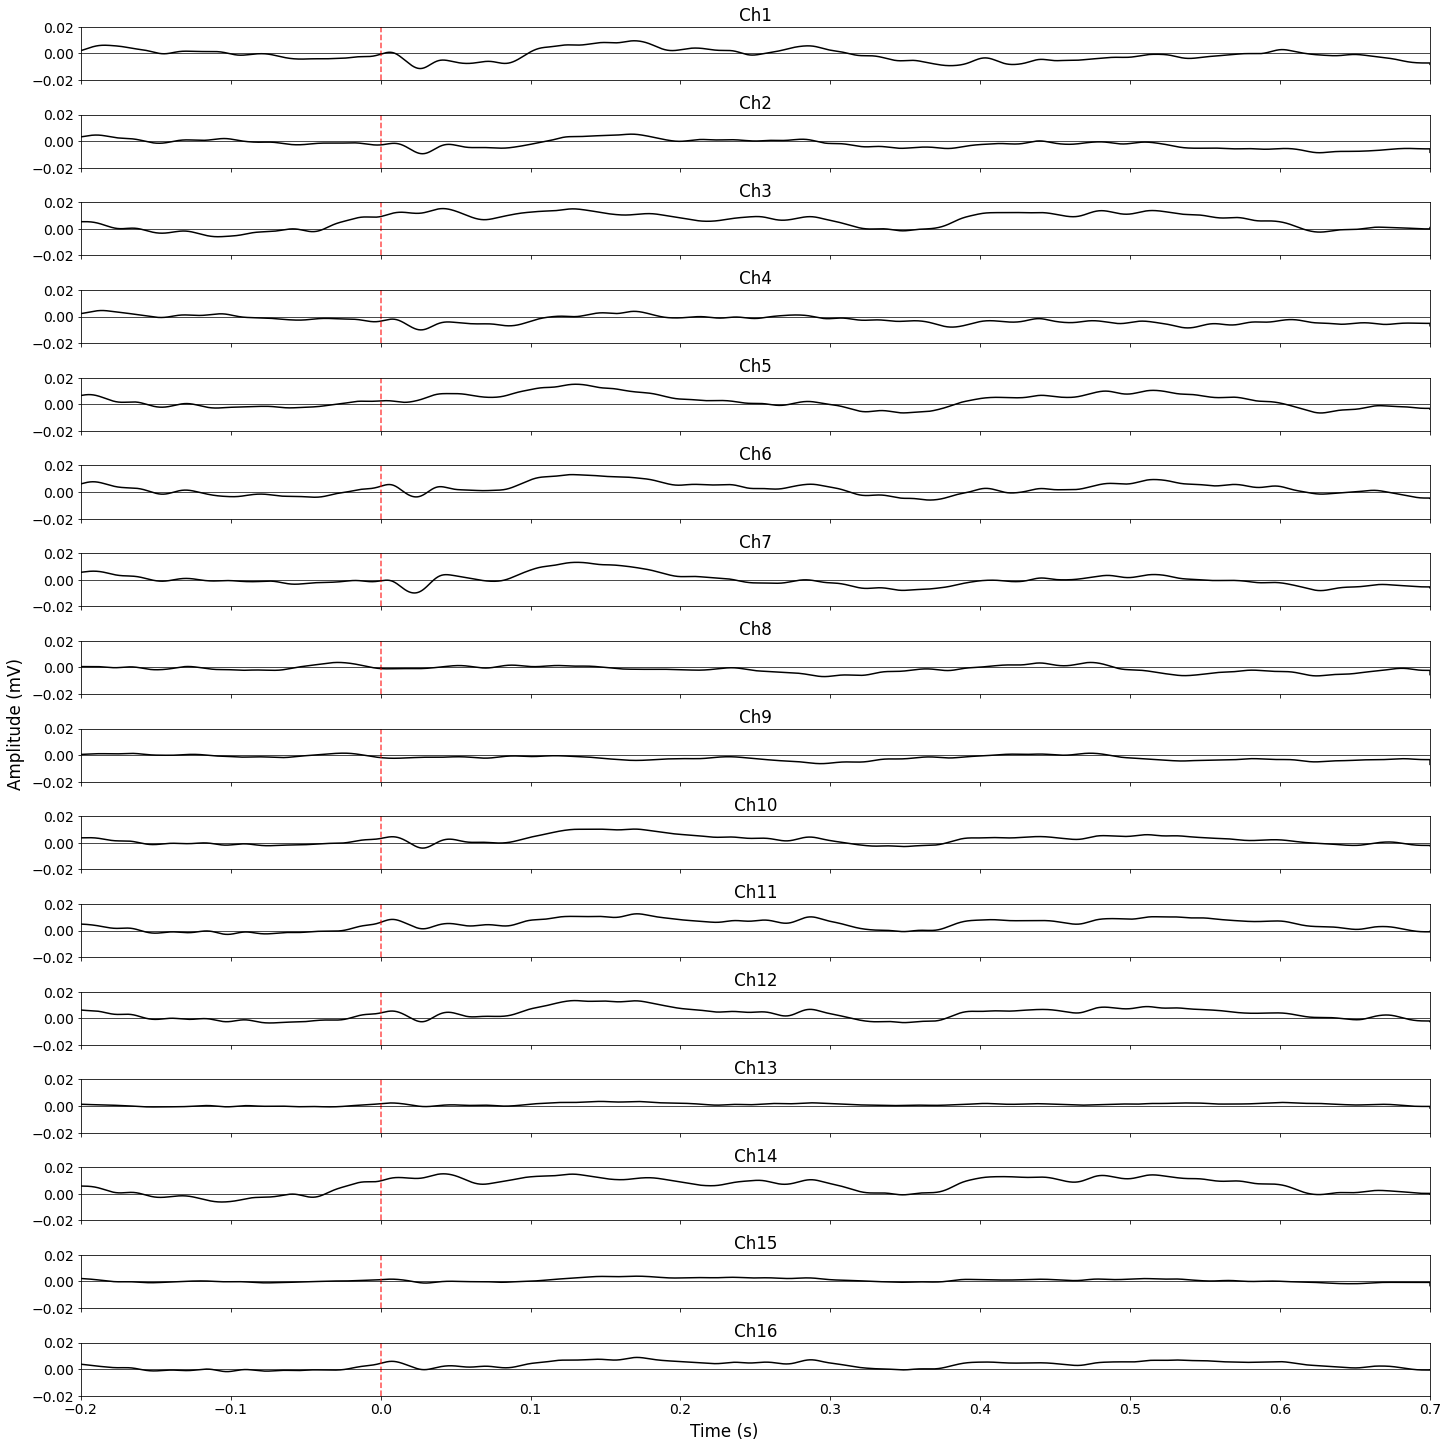

In [72]:
#刺激選択，加算平均（16ch）---------------------------------------------------------------------------------------------
lag = mat['WB03_ts']
lag_sample = int(lag * fs1)

#start_time = mat_data[np.arange(len(mat_data)) % 6 != 5] + cut_left 
#start_time = mat_data[np.arange(len(mat_data)) % 6 == 5] + cut_left 
#start_time = mat_data[np.logical_not(np.isin(np.arange(len(mat_data)), selected_indices))] + cut_left
start_time = mat_data[selected_indices] + cut_left

lists_st = [] 
for sample in start_time:
    start_sample = int(sample * fs1 - lag_sample)
    lists_st.append(start_sample) 
    #print(start_sample)

#end_time = mat_data[np.arange(len(mat_data)) % 6 != 5] + cut_right 
#end_time = mat_data[np.arange(len(mat_data)) % 6 == 5] + cut_right 
#end_time = mat_data[np.logical_not(np.isin(np.arange(len(mat_data)), selected_indices))] + cut_right
end_time = mat_data[selected_indices] + cut_right

lists_ed = []
for sample2 in end_time:
    end_sample = int(sample2 * fs1 - lag_sample)
    lists_ed.append(end_sample)
    #print(end_sample)


fig, axes = plt.subplots(16, 1, figsize=(20,20), constrained_layout=True, sharex=True, sharey=True)

amp_sum = []
amp_del = [] #数が合わない用

ampsum_leave1 = [] #残す用
ampsum_leave2 = []
ampsum_leave3 = []
ampsum_leave4 = []
ampsum_leave5 = []
ampsum_leave6 = []
ampsum_leave7 = []
ampsum_leave8 = []
ampsum_leave9 = []
ampsum_leave10 = []
ampsum_leave11 = []
ampsum_leave12 = []
ampsum_leave13 = []
ampsum_leave14 = []
ampsum_leave15 = []
ampsum_leave16 = []


for No in range(1, 17):
   amp_sum.clear()
   for i in range(len(lists_st)):
      ss = lists_st[i]
      ed = lists_ed[i]
      amp = [np.concatenate(mat[f'{WB}{No:02}'][ss:ed])]
      data_lofilt = lowpass(amp, samplerate, fp, fs, gpass, gstop)


      if len(data_lofilt[0])==analy_len:
         A = [data_lofilt.T]
      elif len(data_lofilt[0])==analy_len-1:
         data_lofilt = np.append(data_lofilt, 0)
         data_lofilt = data_lofilt.reshape(1,analy_len)
         A = [data_lofilt.T]
      elif len(data_lofilt[0])==analy_len+1:
         data_lofilt = np.delete(data_lofilt, -1)
         data_lofilt = data_lofilt.reshape(1,analy_len)
         A = [data_lofilt.T]


      #A = [data_lofilt.T]
      if len(A[0])==analy_len:#40000:
         amp_sum += A
      else:
         amp_del += A
      
   ave = np.mean(amp_sum,axis=0)
   new_ave = list(map(lambda G: G - globals()['ampsum_baseleave%s'%No][0], ave))
   axes[No-1].set_title(f'{Ch}{No}')
   axes[No-1].plot(time,new_ave,color='k')
   axes[No-1].set_xlim(cut_left, cut_right)
   axes[No-1].set_ylim(-0.02, 0.02)
   axes[No-1].vlines(x=0, ymin=-0.02, ymax=0.02, color='r', alpha=.7, linestyles='dashed')
   axes[No-1].hlines(y=0, xmin=cut_left, xmax=cut_right, color='k', linewidth=0.7)
   fig.supxlabel("Time (s)")
   fig.supylabel("Amplitude (mV)")   
   
   if len(ampsum_leave1)==0:
      ampsum_leave1.extend(amp_sum)
   elif len(ampsum_leave2)==0:
      ampsum_leave2.extend(amp_sum)
   elif len(ampsum_leave3)==0:
      ampsum_leave3.extend(amp_sum)  
   elif len(ampsum_leave4)==0:
      ampsum_leave4.extend(amp_sum)
   elif len(ampsum_leave5)==0:
      ampsum_leave5.extend(amp_sum) 
   elif len(ampsum_leave6)==0:
      ampsum_leave6.extend(amp_sum)
   elif len(ampsum_leave7)==0:
      ampsum_leave7.extend(amp_sum)  
   elif len(ampsum_leave8)==0:
      ampsum_leave8.extend(amp_sum)
   elif len(ampsum_leave9)==0:
      ampsum_leave9.extend(amp_sum)
   elif len(ampsum_leave10)==0:
      ampsum_leave10.extend(amp_sum)
   elif len(ampsum_leave11)==0:
      ampsum_leave11.extend(amp_sum) 
   elif len(ampsum_leave12)==0:
      ampsum_leave12.extend(amp_sum)  
   elif len(ampsum_leave13)==0:
      ampsum_leave13.extend(amp_sum)
   elif len(ampsum_leave14)==0:
      ampsum_leave14.extend(amp_sum) 
   elif len(ampsum_leave15)==0:
      ampsum_leave15.extend(amp_sum)
   elif len(ampsum_leave16)==0:
      ampsum_leave16.extend(amp_sum)  

pictname = "fig"
plt.savefig(root/pictname, bbox_inches="tight")

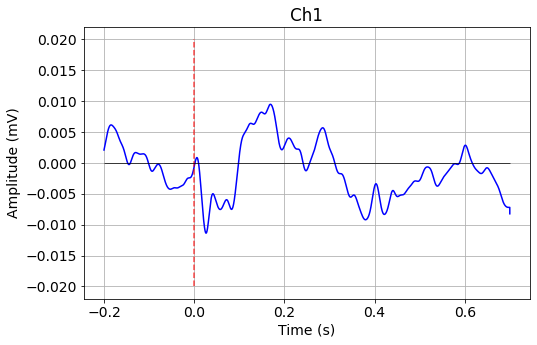

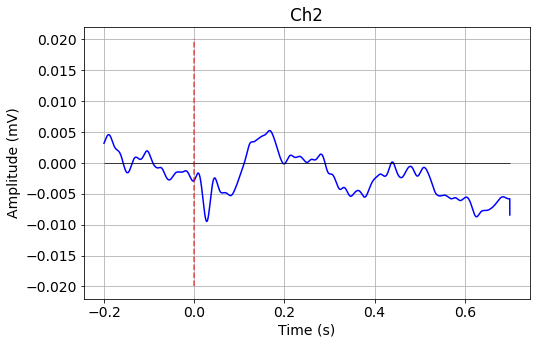

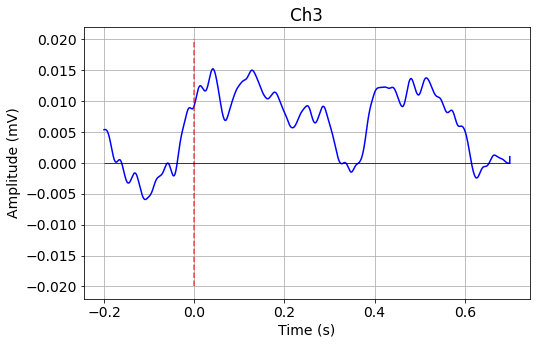

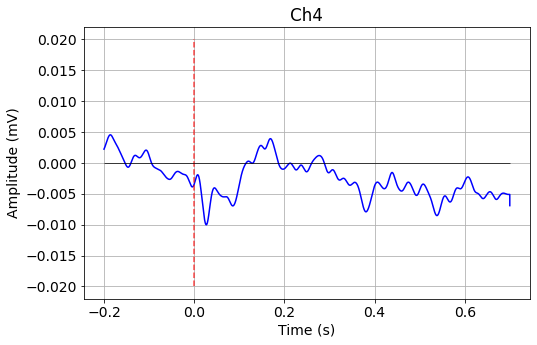

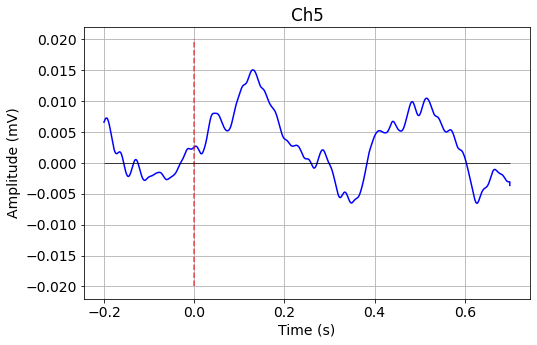

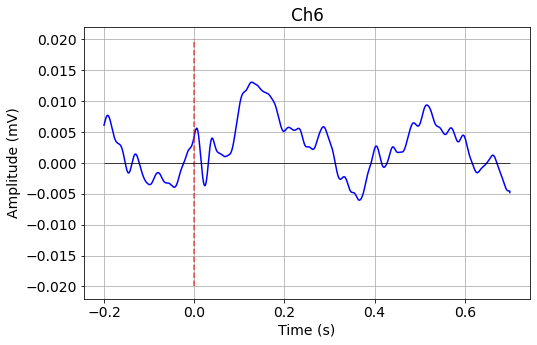

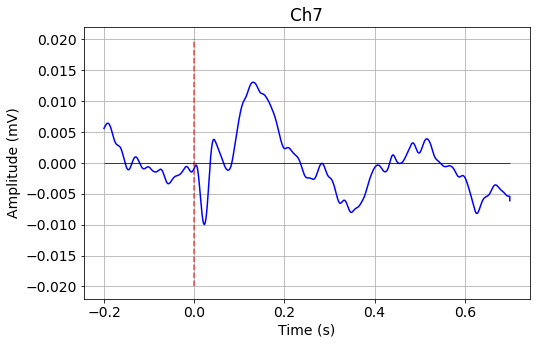

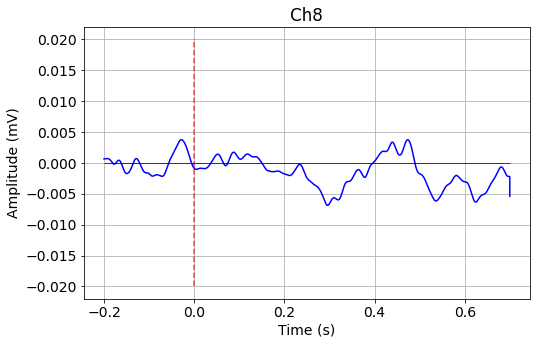

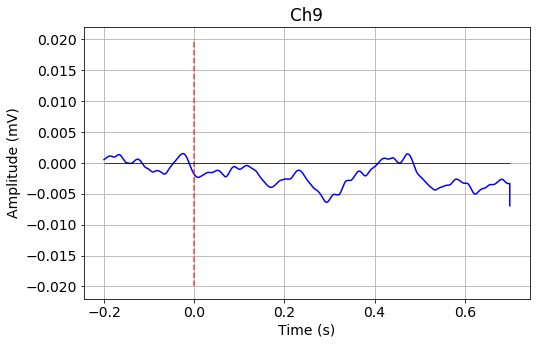

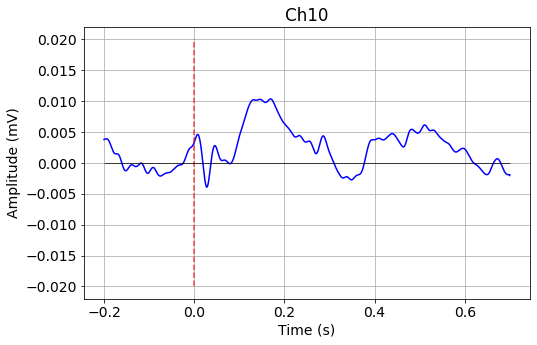

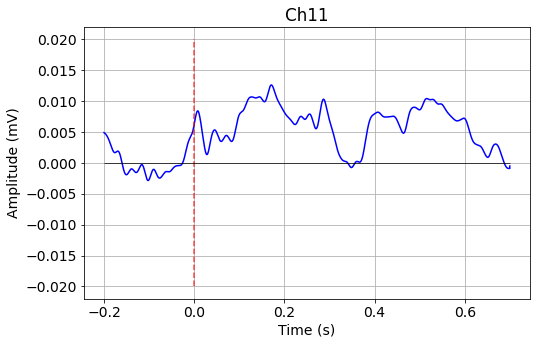

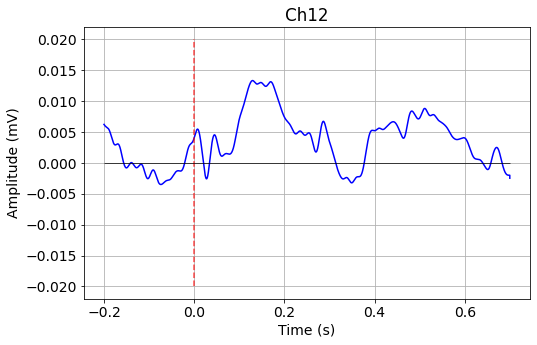

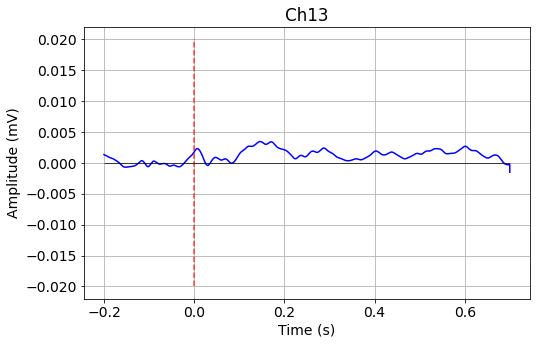

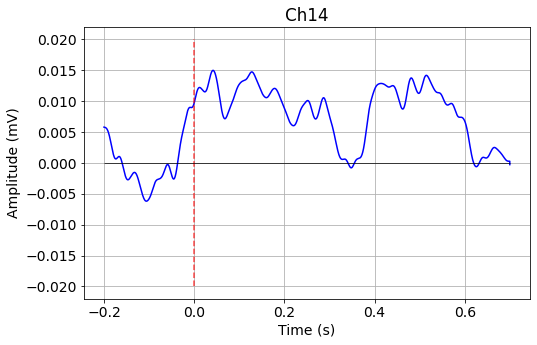

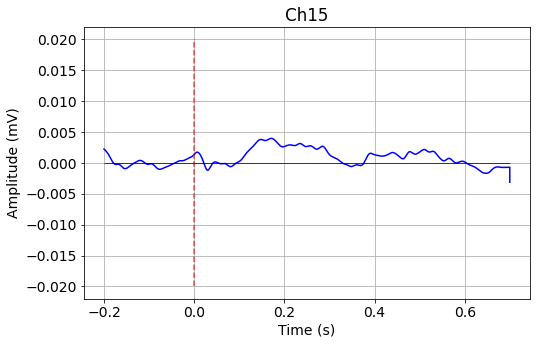

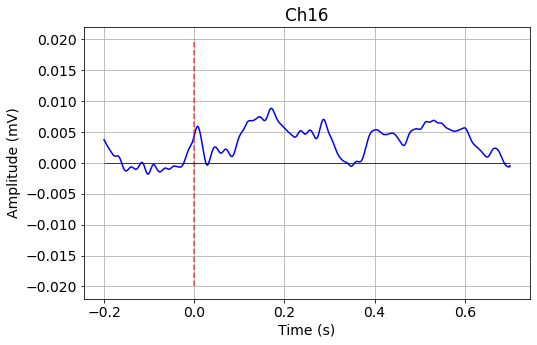

In [73]:
#mean残す用
mean_leave1 = [] #残す用
mean_leave2 = []
mean_leave3 = []
mean_leave4 = []
mean_leave5 = []
mean_leave6 = []
mean_leave7 = []
mean_leave8 = []
mean_leave9 = []
mean_leave10 = []
mean_leave11 = []
mean_leave12 = []
mean_leave13 = []
mean_leave14 = []
mean_leave15 = []
mean_leave16 = []

#1つずつ出力（平均後波形）-----------------------------------------------------------------------------------------------
for No in range(1, 17):
    fig = plt.figure(figsize=(8,5))
    plt.rcParams["font.size"] = 14
    plt.grid()
    ave4 = np.mean(globals()['ampsum_leave%s'%No],axis=0)
    new_ave4 = list(map(lambda G: G - globals()['ampsum_baseleave%s'%No][0], ave4))
    globals()['mean_leave%s'%No].extend(new_ave4)
    plt.plot(time, new_ave4, color='b')
    plt.title(f'{Ch}{No}')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")
    plt.vlines(x=0, ymin=-0.02, ymax=0.02, color='r', alpha=.7, linestyles='dashed')
    plt.hlines(y=0, xmin=cut_left, xmax=cut_right, color='k', linewidth=0.7)
    plt.show()

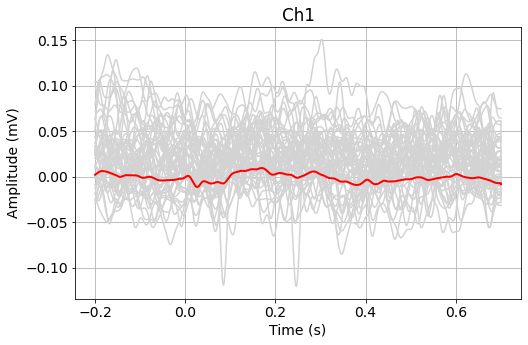

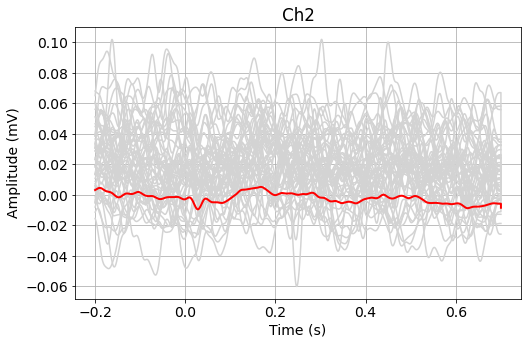

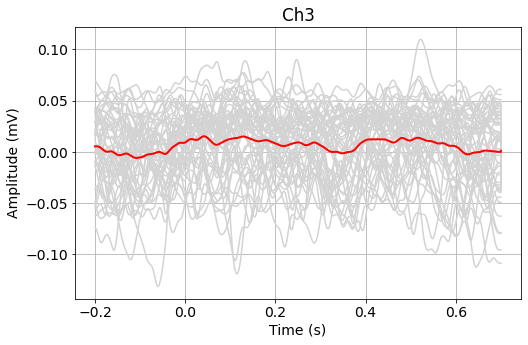

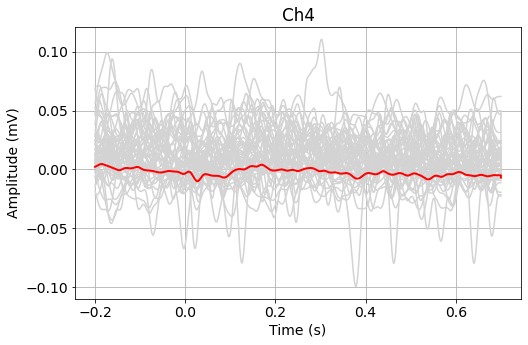

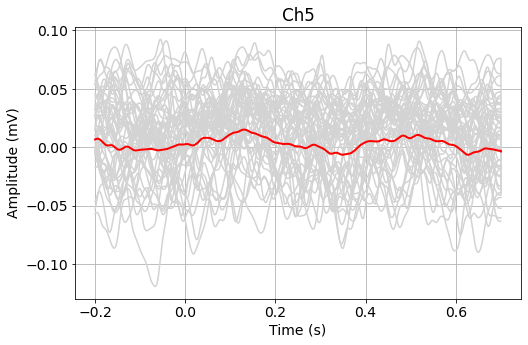

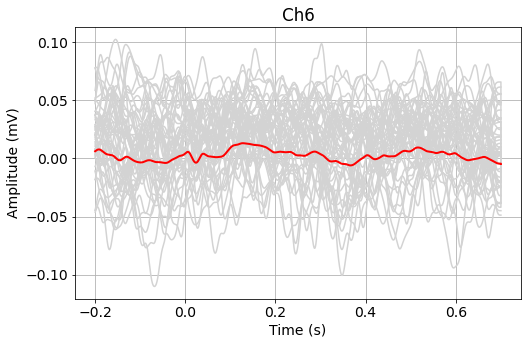

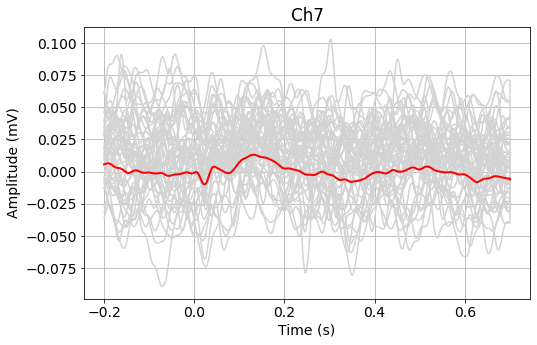

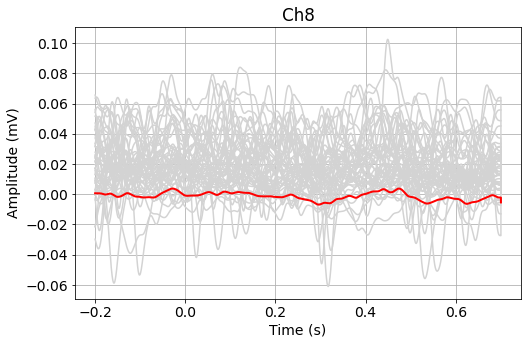

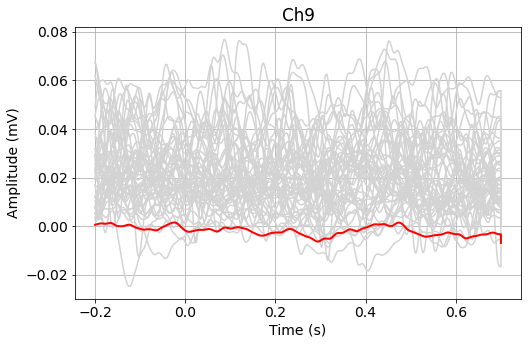

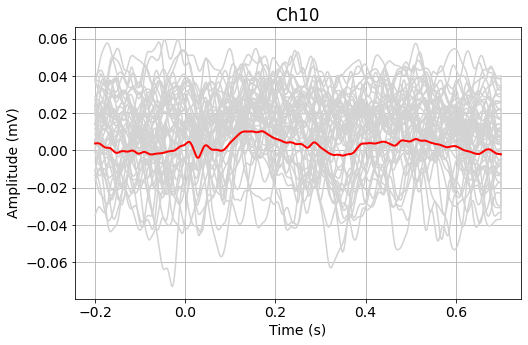

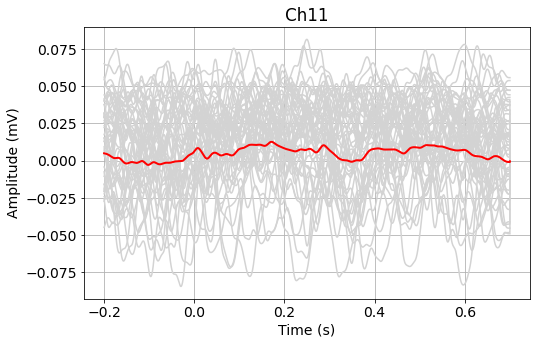

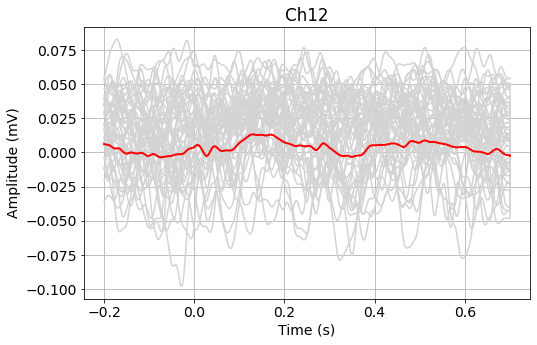

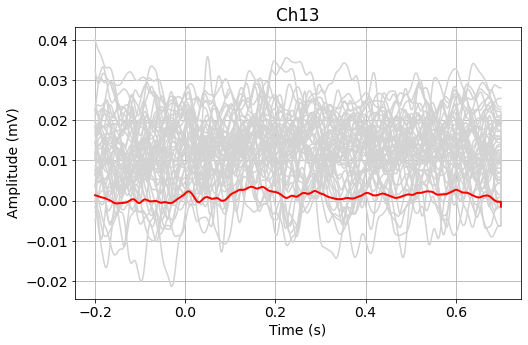

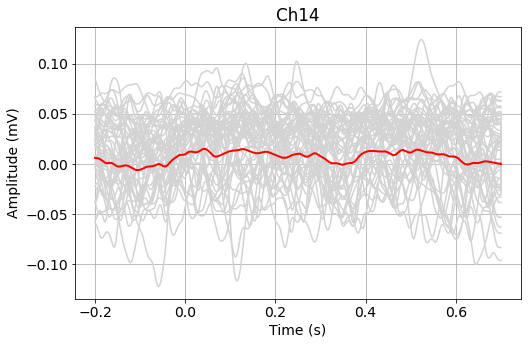

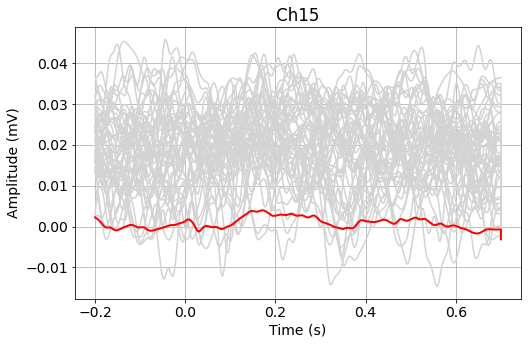

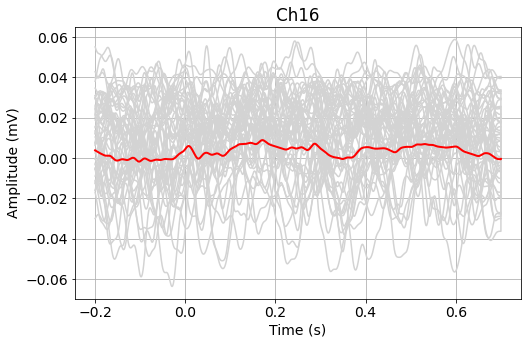

In [74]:
#1つずつ出力（平均前，平均後波形）---------------------------------------------------------------------------------------
for No in range(1, 17):
    fig = plt.figure(figsize=(8,5))
    plt.rcParams["font.size"] = 14
    plt.grid()
    for l in range(len(ampsum_leave1)):
        plt.plot(time, globals()['ampsum_leave%s'%No][l], color='lightgray')
        #plt.ylim(-0.07, 0.07)

    ave3 = np.mean(globals()['ampsum_leave%s'%No],axis=0)
    new_ave3 = list(map(lambda G: G - globals()['ampsum_baseleave%s'%No][0], ave3))
    plt.plot(time, new_ave3, color='r', linewidth=2)
    plt.title(f'{Ch}{No}')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")
    pictname = f'{Ch}{No}'
    plt.savefig(root/pictname, bbox_inches="tight")
    plt.show()

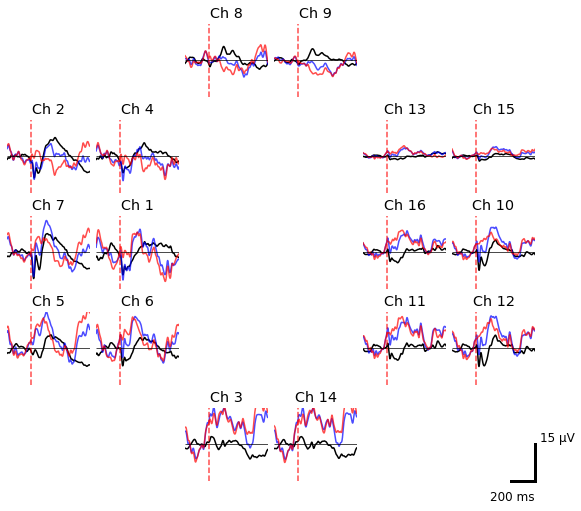

In [77]:
#電極の配置に並べ変える
#fig = plt.figure(figsize=(8,8), constrained_layout=True, facecolor='w')
fig = plt.figure(figsize=(8,8), constrained_layout=True, facecolor='w')
plt.rcParams["font.size"] = 12

ax1 = fig.add_subplot(6, 6, 9)
ax1.set_title("Ch 8")
ax1.plot(time, mean8, color='k')
ax1.plot(time, mean8_8, color='b', alpha=0.7)
ax1.plot(time, result8, color='r', alpha=0.7)

ax2 = fig.add_subplot(6, 6, 10)
ax2.set_title("Ch 9")
ax2.plot(time, mean9, color='k')
ax2.plot(time, mean9_9, color='b', alpha=0.7)
ax2.plot(time, result9, color='r', alpha=0.7)

ax3 = fig.add_subplot(6, 6, 13)
ax3.set_title("Ch 2")
ax3.plot(time, mean2, color='k')
ax3.plot(time, mean2_2, color='b', alpha=0.7)
ax3.plot(time, result2, color='r', alpha=0.7)

ax4 = fig.add_subplot(6, 6, 14)
ax4.set_title("Ch 4")
ax4.plot(time, mean4, color='k')
ax4.plot(time, mean4_4, color='b', alpha=0.7)
ax4.plot(time, result4, color='r', alpha=0.7)

ax5 = fig.add_subplot(6, 6, 17)
ax5.set_title("Ch 13")
ax5.plot(time, mean13, color='k')
ax5.plot(time, mean13_13, color='b', alpha=0.7)
ax5.plot(time, result13, color='r', alpha=0.7)

ax6 = fig.add_subplot(6, 6, 18)
ax6.set_title("Ch 15")
ax6.plot(time, mean15, color='k')
ax6.plot(time, mean15_15, color='b', alpha=0.7)
ax6.plot(time, result15, color='r', alpha=0.7)

ax7 = fig.add_subplot(6, 6, 19)
ax7.set_title("Ch 7")
ax7.plot(time, mean7, color='k')
ax7.plot(time, mean7_7, color='b', alpha=0.7)
ax7.plot(time, result7, color='r', alpha=0.7)

ax8 = fig.add_subplot(6, 6, 20)
ax8.set_title("Ch 1")
ax8.plot(time, mean1, color='k')
ax8.plot(time, mean1_1, color='b', alpha=0.7)
ax8.plot(time, result1, color='r', alpha=0.7)

ax9 = fig.add_subplot(6, 6, 23)
ax9.set_title("Ch 16")
ax9.plot(time, mean16, color='k')
ax9.plot(time, mean16_16, color='b', alpha=0.7)
ax9.plot(time, result16, color='r', alpha=0.7)

ax10 = fig.add_subplot(6, 6, 24)
ax10.set_title("Ch 10")
ax10.plot(time, mean10, color='k')
ax10.plot(time, mean10_10, color='b', alpha=0.7)
ax10.plot(time, result10, color='r', alpha=0.7)

ax11 = fig.add_subplot(6, 6, 25)
ax11.set_title("Ch 5")
ax11.plot(time, mean5, color='k')
ax11.plot(time, mean5_5, color='b', alpha=0.7)
ax11.plot(time, result5, color='r', alpha=0.7)

ax12 = fig.add_subplot(6, 6, 26)
ax12.set_title("Ch 6")
ax12.plot(time, mean6, color='k')
ax12.plot(time, mean6_6, color='b', alpha=0.7)
ax12.plot(time, result6, color='r', alpha=0.7)

ax13 = fig.add_subplot(6, 6, 29)
ax13.set_title("Ch 11")
ax13.plot(time, mean11, color='k')
ax13.plot(time, mean11_11, color='b', alpha=0.7)
ax13.plot(time, result11, color='r', alpha=0.7)

ax14 = fig.add_subplot(6, 6, 30)
ax14.set_title("Ch 12")
ax14.plot(time, mean12, color='k')
ax14.plot(time, mean12_12, color='b', alpha=0.7)
ax14.plot(time, result12, color='r', alpha=0.7)

ax15 = fig.add_subplot(6, 6, 33)
ax15.set_title("Ch 3")
ax15.plot(time, mean3, color='k')
ax15.plot(time, mean3_3, color='b', alpha=0.7)
ax15.plot(time, result3, color='r', alpha=0.7)

ax16 = fig.add_subplot(6, 6, 34)
ax16.set_title("Ch 14")
ax16.plot(time, mean14, color='k')
ax16.plot(time, mean14_14, color='b', alpha=0.7)
ax16.plot(time, result14, color='r', alpha=0.7)

for j in range(1, 17):
    globals()['ax%s'%j].spines['right'].set_visible(False)
    globals()['ax%s'%j].spines['top'].set_visible(False)
    globals()['ax%s'%j].spines['left'].set_visible(False)
    globals()['ax%s'%j].spines['bottom'].set_visible(False)
    globals()['ax%s'%j].set_xlim(cut_left, cut_right-0.2)
    globals()['ax%s'%j].set_ylim(-0.015, 0.015)
    globals()['ax%s'%j].hlines(y=0, xmin=cut_left, xmax=cut_right-0.2, color='k', linewidth=0.7)
    globals()['ax%s'%j].vlines(x=0, ymin=-0.015, ymax=0.015, color='r', alpha=.7, linestyles='dashed')
    globals()['ax%s'%j].tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)


#ax19はスケールバーを疑似的に作成
ax19 = fig.add_subplot(6, 6, 36)
ax19.plot(time, mean_leave1, color="w")
ax19.spines['top'].set_visible(False)
ax19.spines['left'].set_visible(False)
ax19.set_xlim(cut_left, cut_right-0.2)
ax19.set_ylim(-0.015, 0.015)
ax19.set_xlabel('200 ms', loc='right', labelpad=10)#, fontweight='bold')
ax19.set_ylabel('15 µV', rotation='horizontal', labelpad=-105)#, fontweight='bold') #loc='bottom'
ax19.spines.right.set_bounds(-0.015, 0)
ax19.spines.bottom.set_bounds(cut_right-0.4, cut_right-0.2)
ax19.spines.right.set_linewidth(3)
ax19.spines.bottom.set_linewidth(3)
ax19.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)

#ラベルについて
#https://it-mayura.com/python/pm010/

pictname = 'fig3'
plt.savefig(root/pictname, bbox_inches="tight")
plt.show()

In [69]:
#STD

mean1 = mean_leave1
mean2 = mean_leave2
mean3 = mean_leave3
mean4 = mean_leave4
mean5 = mean_leave5
mean6 = mean_leave6
mean7 = mean_leave7
mean8 = mean_leave8
mean9 = mean_leave9
mean10 = mean_leave10
mean11 = mean_leave11
mean12 = mean_leave12
mean13 = mean_leave13
mean14 = mean_leave14
mean15 = mean_leave15
mean16 = mean_leave16

In [75]:
#DEV

mean1_1 = mean_leave1
mean2_2 = mean_leave2
mean3_3 = mean_leave3
mean4_4 = mean_leave4
mean5_5 = mean_leave5
mean6_6 = mean_leave6
mean7_7 = mean_leave7
mean8_8 = mean_leave8
mean9_9 = mean_leave9
mean10_10 = mean_leave10
mean11_11 = mean_leave11
mean12_12 = mean_leave12
mean13_13 = mean_leave13
mean14_14 = mean_leave14
mean15_15 = mean_leave15
mean16_16 = mean_leave16

In [76]:
#DEV-STD
result1 = [x - y for x, y in zip(mean1_1, mean1)]
result2 = [x - y for x, y in zip(mean2_2, mean2)]
result3 = [x - y for x, y in zip(mean3_3, mean3)]
result4 = [x - y for x, y in zip(mean4_4, mean4)]
result5 = [x - y for x, y in zip(mean5_5, mean5)]
result6 = [x - y for x, y in zip(mean6_6, mean6)]
result7 = [x - y for x, y in zip(mean7_7, mean7)]
result8 = [x - y for x, y in zip(mean8_8, mean8)]
result9 = [x - y for x, y in zip(mean9_9, mean9)]
result10 = [x - y for x, y in zip(mean10_10, mean10)]
result11 = [x - y for x, y in zip(mean11_11, mean11)]
result12 = [x - y for x, y in zip(mean12_12, mean12)]
result13 = [x - y for x, y in zip(mean13_13, mean13)]
result14 = [x - y for x, y in zip(mean14_14, mean14)]
result15 = [x - y for x, y in zip(mean15_15, mean15)]
result16 = [x - y for x, y in zip(mean16_16, mean16)]

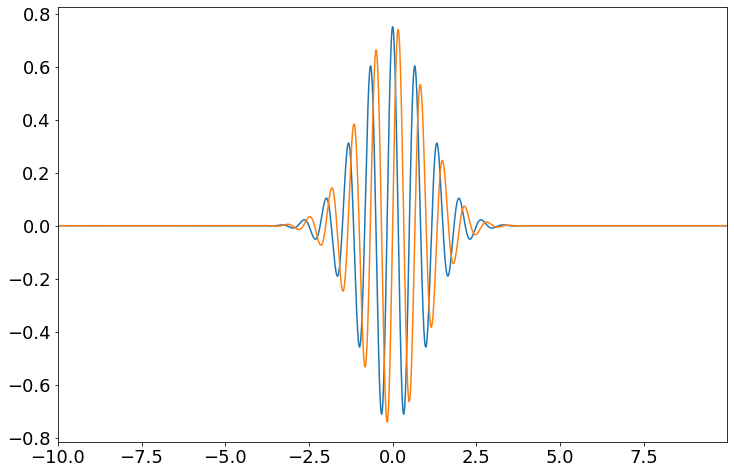

In [9]:
#https://teratail.com/questions/il7fzaga9vko9e マザーウェーブレットのオメガを変更することによる波形の変化
#https://www.jstage.jst.go.jp/article/ieejjournal/129/10/129_10_660/_pdf

Xx = np.arange(-10.0, 10.0, 0.001)
Yy = pycwt.Morlet(1.5).psi(Xx)
plt.plot(Xx, Yy.real, Xx, Yy.imag)
plt.show()

In [17]:
#辞書型でNew_meanleaveを作った
#1000倍して，µVに直すといい感じ

lists_dict = {}
num_lists = 16

for i in range(1, num_lists+1):
    list_name = f'New_meanleave{i}'
    lists_dict[list_name] = []
    lists_dict[list_name].extend(X*1000 for X in globals()['mean_leave%s'%i])


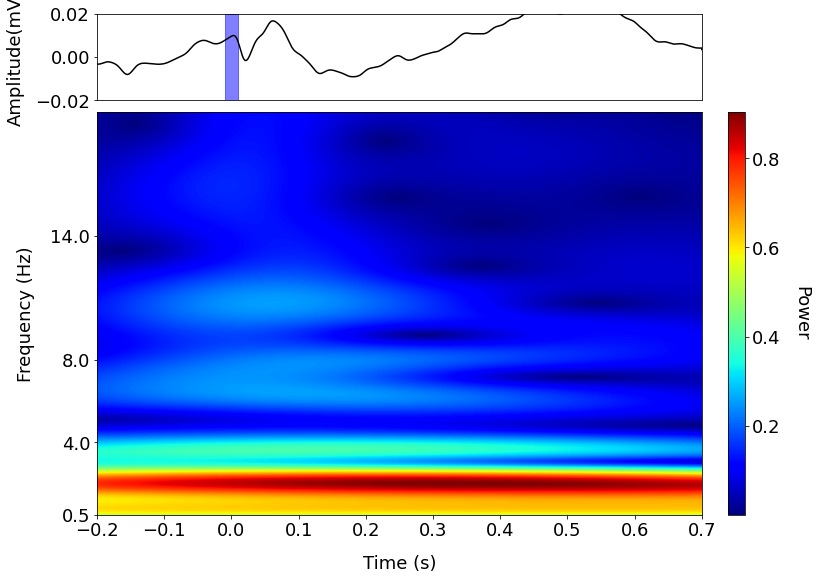

In [21]:
#wavelet変換
#参考になりそう,https://www.docswell.com/s/rtachi-lab/KLP3G5-2022-08-28-155727#p26

NFs = 40000
time2 = np.linspace(-0.2, 0.7, 36000)

fmin = 0.5
fmax = 20
fstep = 0.1
freqs = np.arange(fmin, fmax+fstep, fstep)
omega0 = 2

#y = np.array(ampsum_leave8[9])
y = np.array(mean_leave10)  #lists_dict['New_meanleave10'])
r1 = pycwt.cwt_f(y[:,0], freqs, NFs, pycwt.Morlet(omega0))
rr1 = np.abs(r1)


plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams["font.size"] = 18
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

#https://note.nkmk.me/python-matplotlib-default-axes-range-margin/
plt.rcParams['axes.xmargin'] = 0

fig = plt.figure()
#https://www.python.ambitious-engineer.com/archives/2680
ax1 = fig.add_axes([0.1, 0.82, 0.7, 0.15]) #[x0,y0,width,height]
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.7])
ax3 = fig.add_axes([0.83, 0.1, 0.02, 0.7])

ax1.plot(time2, y, 'k')
ax1.set_xticks([])
ax1.axvspan(-0.01, 0.01, color="b", alpha=0.5)
ax1.set_ylim(-0.02, 0.02)
ax1.set_yticks([-0.02,0,0.02])
ax1.set_ylabel('Amplitude(mV)', labelpad=10)
# ax1.yaxis.set_label_position("right")
# ax1.yaxis.tick_right()

#cmap='plasma'
im = ax2.imshow(np.flipud(rr1), extent=[time2[0], time2[-1], freqs[0], freqs[-1]], cmap='jet', aspect='auto', interpolation='spline16')
ax2.set_yticks([0.5, 4, 8, 14])
ax2.set_xlabel('Time (s)', labelpad=15)
ax2.set_ylabel('Frequency (Hz)', labelpad=15)
fig.colorbar(im, cax=ax3).set_label(label='Power', rotation=270, labelpad=30)

plt.show()

In [10]:
#これはCWTで0.5から20Hzを0.1刻みでやっている
#つまり，20-0.5=19.5 19.5/0.1=195となっている
len(rr1)

196

In [11]:
#今解析してる時間長やから36000は当たり前
len(rr1[0])

36000

In [12]:
#CWTの周波数パワーを調べるときに使う用（index）

number_Hz = []

for i in range(196):
    result = 0.5 + 0.1 * i
    number_Hz.append(result)

target_number = 10
if target_number in number_Hz:
    index = number_Hz.index(target_number)
    print(f"The index of {target_number} is: {index}")
else:
    print(f"{target_number} is not in the list.")

The index of 10 is: 95


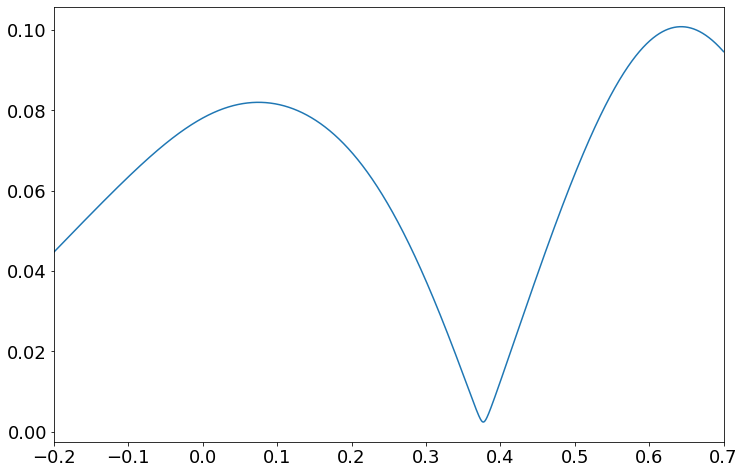

In [13]:
plt.plot(time2, rr1[95], marker='')

In [7]:
#STFTするのにそのままmean_leaveを使うと値が小さくて（mv表示のため）dB値が小さくなる
#1000倍して，µVに直すといい感じ

meanleave10_new = [X*1000 for X in mean_leave10]

C:\Users\Hokud\AppData\Local\Temp\ipykernel_31476\1254515116.py:12: RuntimeWarning: divide by zero encountered in log
  Zxx = 10 * np.log(np.abs(Zxx))


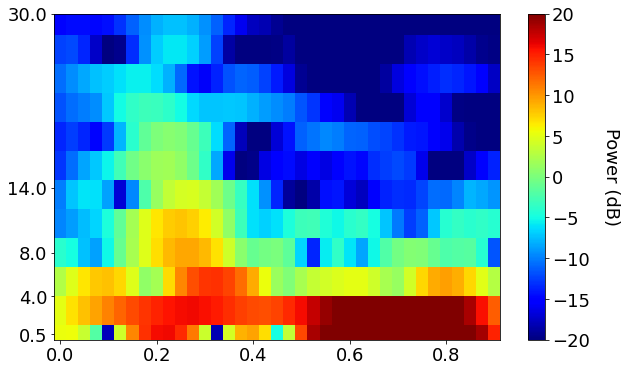

In [8]:
#STFT
#print(ave.size / fs)
plt.figure(figsize=(10,6))
plt.rcParams["font.size"] = 18
frq, t, Zxx = scipy.signal.stft(
    #np.ravel(ampsum_leave8[9]),
    np.ravel(meanleave10_new),
    fs = fs1,
    nperseg = 15000, # 時間幅, 最初10000
    noverlap = 14000 # 重ね幅，最初9000
)
Zxx = 10 * np.log(np.abs(Zxx))
#Zxx = abs(Zxx)
plt.pcolormesh(t, frq, Zxx, cmap="jet", vmin=-20, vmax=20, shading="auto")
plt.ylim(0, 30)
custom_ticks = [0.5, 4, 8, 14, 30]
plt.yticks(custom_ticks)
# plt.ylabel("Frequency (Hz)", labelpad=15)
# plt.xlabel("Time (s)", labelpad=15)
# plt.title("Depth from brain surface = 500 µm (L4)")
plt.colorbar().set_label(label='Power (dB)', rotation=270, labelpad=30)
#plt.savefig("figures/spectrum_iTBS_noise_removed.png", dpi=200)
#plt.tick_params(labelbottom=False, labelleft=False, labelright=False)#, labeltop=False, bottom=False, left=False, right=False, top=False)
plt.show()

C:\Users\Hokud\AppData\Local\Temp\ipykernel_13856\1821806534.py:15: RuntimeWarning: divide by zero encountered in log
  Zxx = 10 * np.log(np.abs(Zxx))


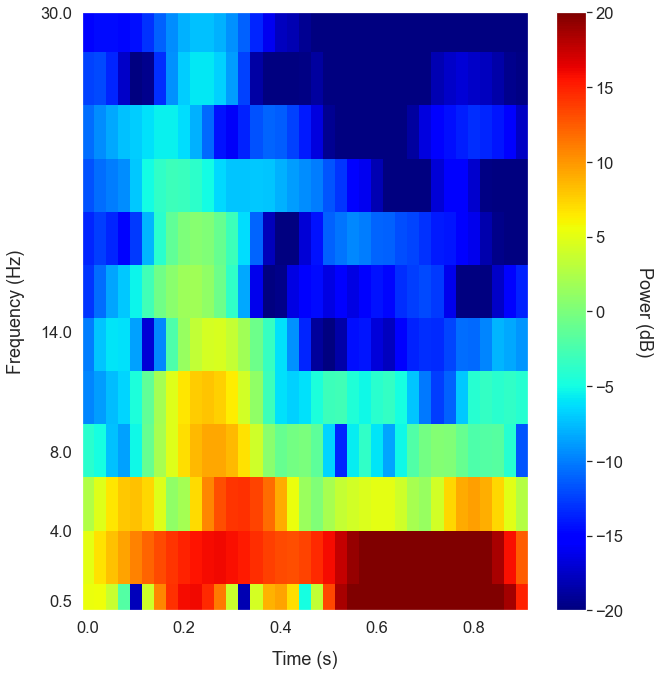

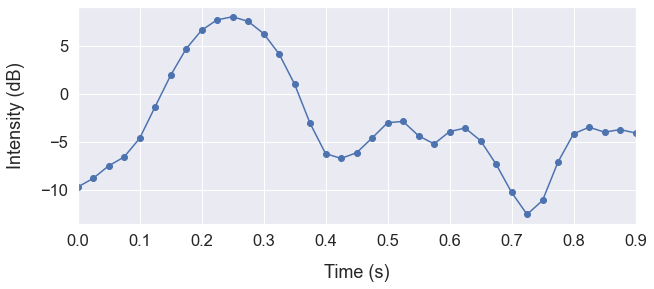

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

# サンプルデータ meanleave8_new（36000点のデータ）を仮で作成します
#meanleave8_new = np.random.rand(36000)

# STFTを実行
frq, t, Zxx = scipy.signal.stft(
    np.ravel(meanleave10_new),
    fs=40000,
    nperseg=15000,
    noverlap=14000
)
Zxx = 10 * np.log(np.abs(Zxx))

# STFT結果をプロット
plt.figure(figsize=(10, 11))
plt.rcParams["font.size"] = 35
plt.pcolormesh(t, frq, Zxx, cmap="jet", vmin=-20, vmax=20, shading="auto")
plt.ylim(0, 30)
custom_ticks = [0.5, 4, 8, 14, 30]
plt.yticks(custom_ticks)
plt.ylabel("Frequency (Hz)", labelpad=15)
plt.xlabel("Time (s)", labelpad=15)
plt.colorbar().set_label(label='Power (dB)', rotation=270, labelpad=30)

# 特定の周波数を取得する関数を定義
def get_intensity_at_frequency(frequency, frequencies, time_bins, spectrogram):
    freq_index = np.argmin(np.abs(frequencies - frequency))
    intensity = spectrogram[freq_index]
    return time_bins, intensity

# 特定の周波数を指定して強度を取得
target_frequency = 10 # 例として10Hzの周波数を取得すると仮定
time_bins, intensity = get_intensity_at_frequency(target_frequency, frq, t, Zxx)

# 特定の周波数の強度をプロット
plt.figure(figsize=(10, 4))
plt.plot(time_bins, intensity, marker='o')
plt.xlabel("Time (s)", labelpad=15)
plt.ylabel("Intensity (dB)", labelpad=15)
plt.show()

In [66]:
#取り出す強度の範囲（0.1sから0.3s，STFTの時間軸おかしいけど0.3sが実際の刺激後0.1s）
time_bins[20:29]

array([0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 , 0.675, 0.7  ])

In [105]:
intensity[12:21]

array([-11.83083462, -12.65056839, -13.30610592, -13.26599381,
       -12.53349617, -11.80474418, -11.26978712, -10.87433837,
       -10.89768555])

In [136]:
listintensity = []
listintensity.append(intensity[20:29])

In [131]:
toukei = listintensity
df3 = pd.DataFrame(toukei)
df3 = df3.T
df3.columns=["2Hz"]
df3 = df3.set_index("2Hz")
df3


""
2Hz
11.101457
11.930372
12.868824
13.626051
14.015261
13.944395
13.424079
12.669143
11.966826


In [137]:
toukei2 = listintensity[0].T
df3["10Hz"] = toukei2
df3

,6Hz,10Hz
2Hz,,
11.101457,1.012938,-3.657049
11.930372,4.554558,-3.381015
12.868824,6.214507,-2.836218
13.626051,6.404195,-3.260459
14.015261,5.289716,-4.338783
13.944395,2.905107,-5.317537
13.424079,-0.918873,-6.292797
12.669143,-7.485469,-7.254687
11.966826,-21.392137,-8.187048


In [138]:
savefile = "30match8_STFT_P300.csv"
df3.to_csv(savefile, encoding="utf_8_sig")

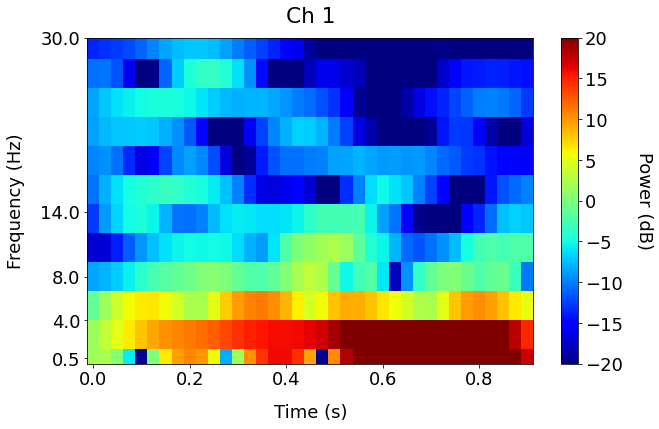

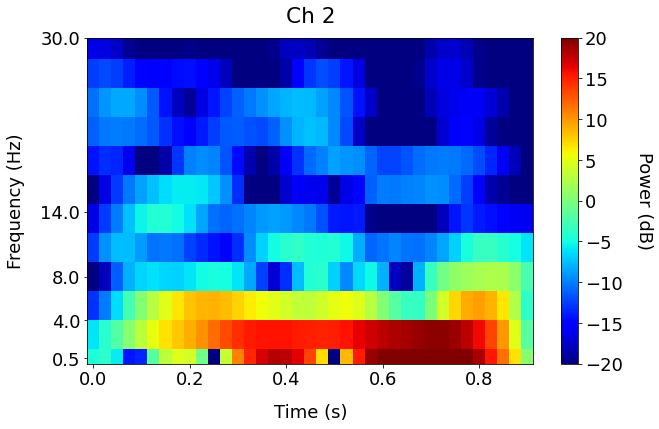

C:\Users\Hokud\AppData\Local\Temp\ipykernel_13856\2982217613.py:12: RuntimeWarning: divide by zero encountered in log
  Zxx = 10 * np.log(np.abs(Zxx))


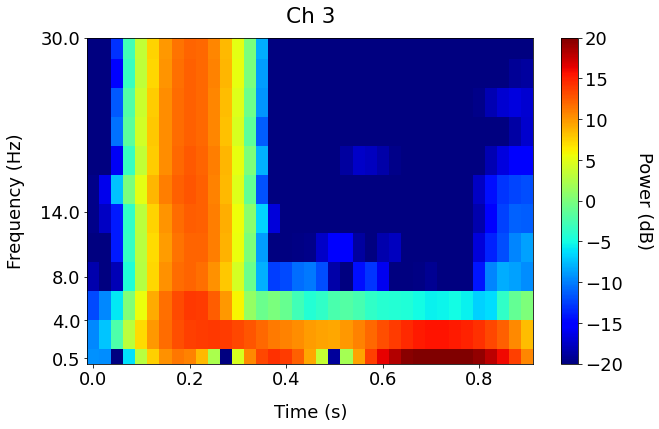

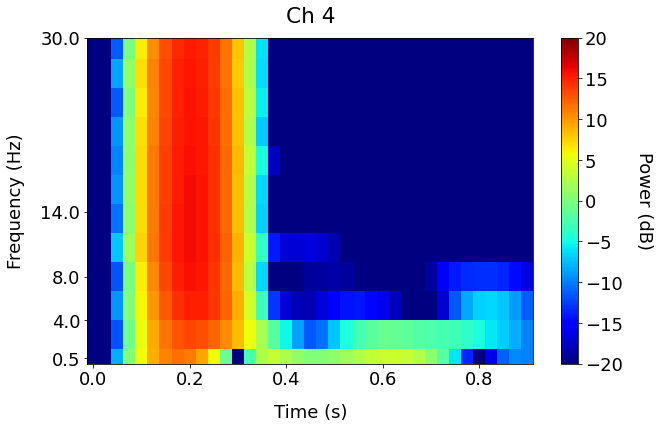

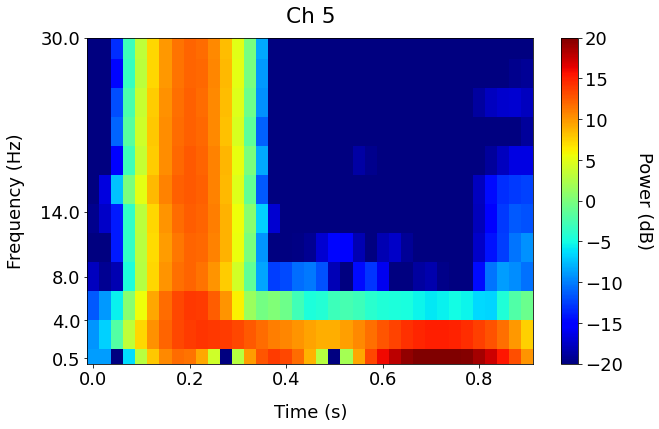

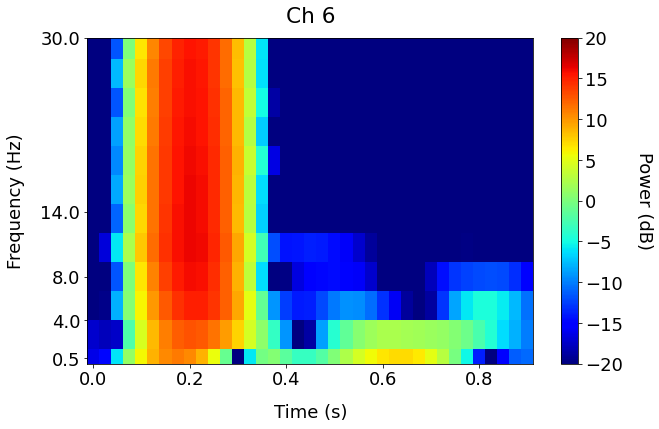

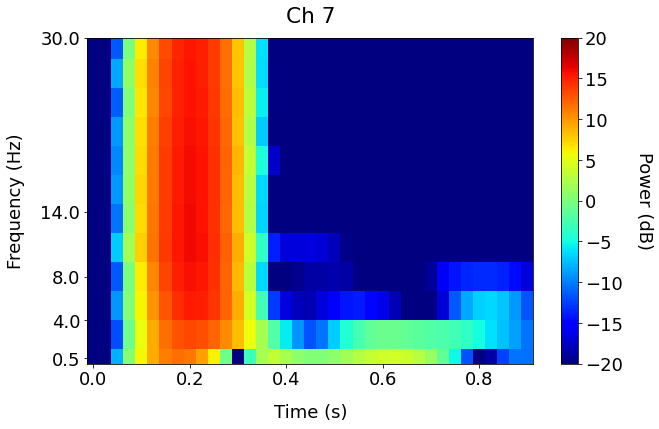

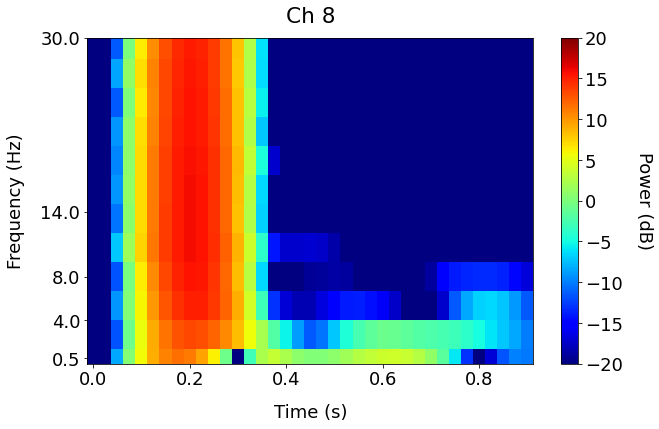

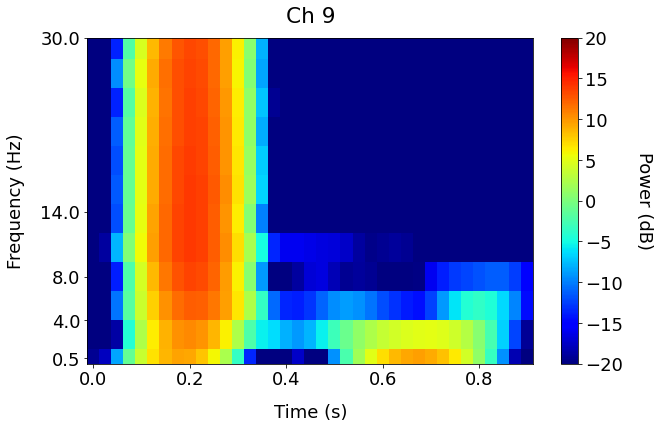

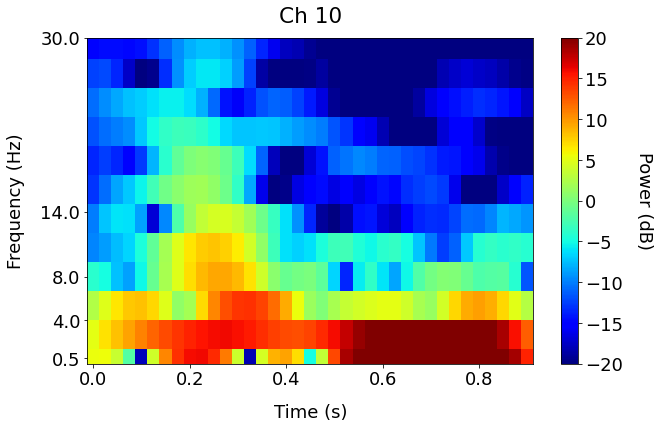

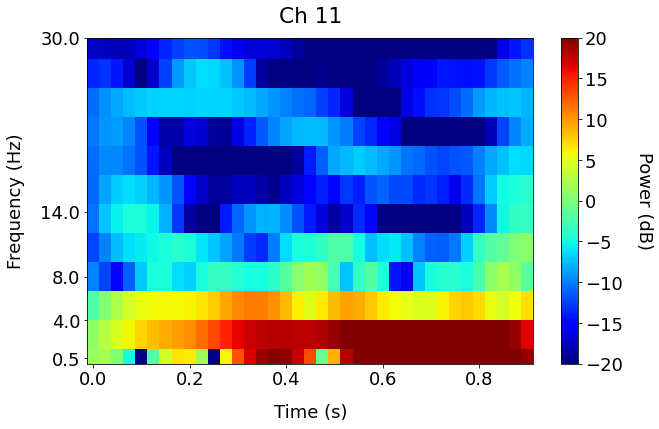

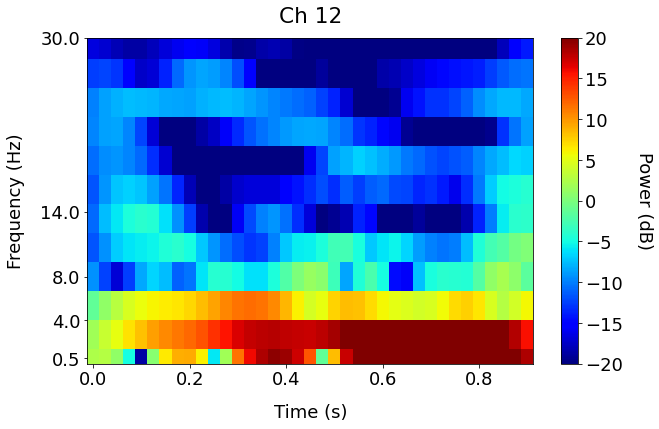

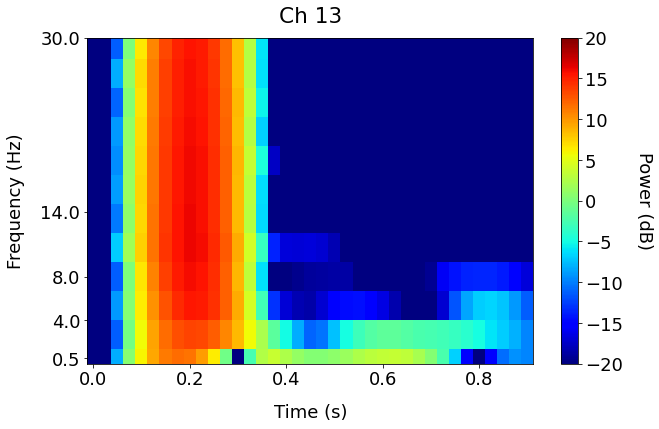

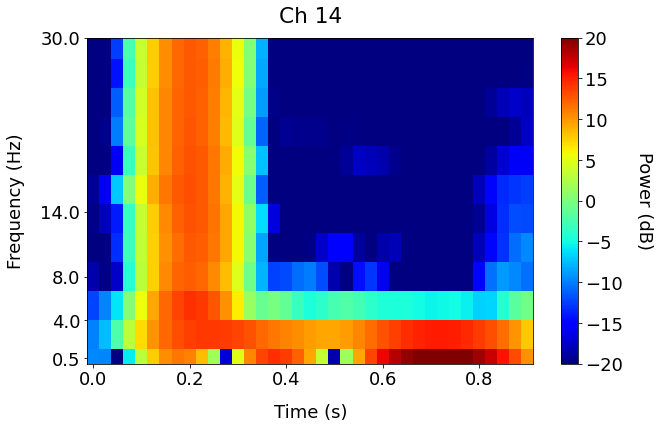

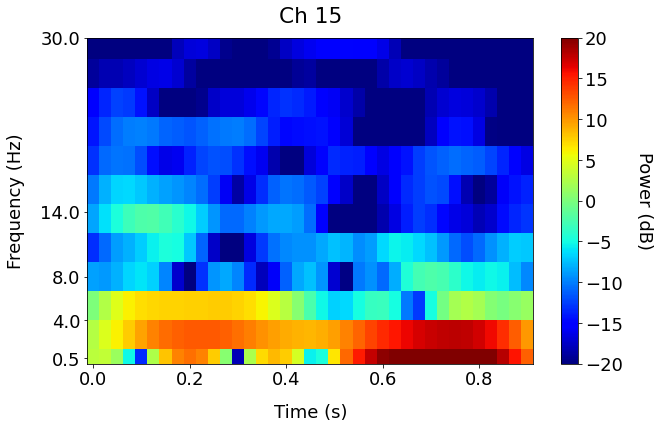

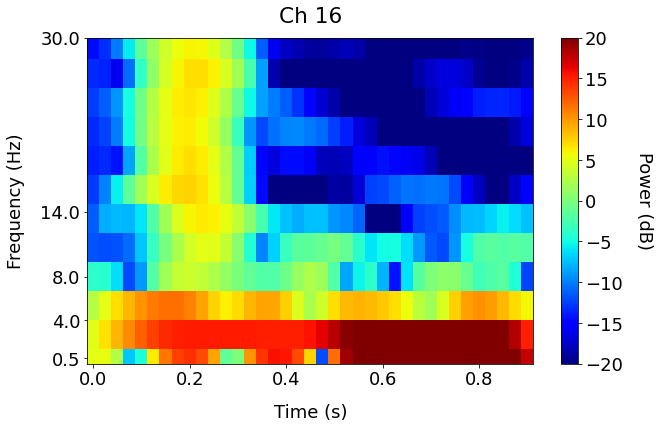

In [30]:
#STFT
for i in range(1,17):
    plt.figure(figsize=(10,6))
    plt.rcParams["font.size"] = 18
    globals()['New_meanleave%s'%i] = [X*1000 for X in globals()['mean_leave%s'%i]]
    frq, t, Zxx = scipy.signal.stft(
        np.ravel(globals()['New_meanleave%s'%i]),
        fs = 40000,
        nperseg = 15000, # 時間幅, 最初10000
        noverlap = 14000 # 重ね幅，最初9000
    )
    Zxx = 10 * np.log(np.abs(Zxx))
    #Zxx = abs(Zxx)
    plt.pcolormesh(t, frq, Zxx, cmap="jet", vmin=-20, vmax=20, shading="auto")
    plt.ylim(0,30)
    custom_ticks = [0.5, 4, 8, 14, 30]
    plt.yticks(custom_ticks)
    plt.ylabel("Frequency (Hz)", labelpad=15)
    plt.xlabel("Time (s)", labelpad=15)
    plt.title(f'{Ch} {i}', pad=15)
    plt.colorbar().set_label(label='Power (dB)', rotation=270, labelpad=30)
    pictname = 'STFT' + f'{Ch}{i}'
    plt.savefig(root/pictname, bbox_inches="tight")
    plt.show()

振幅データそのままの場合の相関行列が以下のプログラム

In [18]:
# #相関行列を作るためにampsum_leaveの50回分のデータから，各回の特定の要素を取り出し，保存

# soukan1 = []
# soukan2 = []
# soukan3 = []
# soukan4 = []
# soukan5 = []
# soukan6 = []
# soukan7 = []
# soukan8 = []
# soukan9 = []
# soukan10 = []
# soukan11 = []
# soukan12 = []
# soukan13 = []
# soukan14 = []
# soukan15 = []
# soukan16 = []

# for i in range(1, 17):
#     for j in range(len(ampsum_leave8)):
#         globals()['soukan%s'%i].append(min(globals()['ampsum_leave%s'%i][j][8000:16000]))


In [19]:
# # データフレームに変換

# df1 = pd.DataFrame({
#     'Ch1': soukan1,
#     'Ch2': soukan2,
#     'Ch3': soukan3,
#     'Ch4': soukan4,
#     'Ch5': soukan5,
#     'Ch6': soukan6,
#     'Ch7': soukan7,
#     'Ch8': soukan8,
#     'Ch9': soukan9,
#     'Ch10': soukan10,
#     'Ch11': soukan11,
#     'Ch12': soukan12,
#     'Ch13': soukan13,
#     'Ch14': soukan14,
#     'Ch15': soukan15,
#     'Ch16': soukan16,
# })

# #上記のままだとデータフレームの中の数値が[]で囲われているから直す
# df1 = df1.astype(float)

# # 相関行列を計算
# correlation_matrix = df1.corr()

# # ヒートマップを描画
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title('Channel Correlation Heatmap')
# plt.show()

In [20]:
# #参考：https://www.nemotos.net/?p=4992

# from heatmap import corrplot
# import numpy as np
# import seaborn as sns
# import pandas as pd
# from matplotlib import pyplot as plt
# from pylab import rcParams

# plt.figure(figsize=(10, 10))
# sns.set(color_codes=True, font_scale=1.5)

# # ヒートマップの作成
# plt.figure(figsize=(8, 8))
# corrplot(df1.corr(), size_scale=300)

 
# # 図の保存と表示
# #plt.savefig('advanced_heatmap.png')
# plt.show()

In [21]:
#ChatGPT
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 仮想的なデータを作成する（実際のデータに置き換える必要があります）
# np.random.seed(42)
# data = np.random.rand(16, 50)

# # データをPandas DataFrameに変換
# df = pd.DataFrame(data.T, columns=[f'Ch{i}' for i in range(1, 17)])

# # 相関行列を計算
# correlation_matrix = df.corr()

# # ヒートマップを描画
# plt.figure(figsize=(20, 18))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title('Channel Correlation Heatmap')
# plt.show()

振幅データそのままではなく，正規化したデータで相関行列を作る

In [9]:
#そのままの数値で相関行列取るのではなく，正規化した数値で行う
#手法は，Min-Max法とZ-Score法のどちらか

def min_max_normalize(data):
    min_val = min(data)
    max_val = max(data)
    normalized_data = [(x - min_val) / (max_val - min_val) for x in data]
    return normalized_data

def z_score_normalize(data):
    mean = sum(data) / len(data)
    variance = sum((x - mean) ** 2 for x in data) / len(data)
    std_dev = variance ** 0.5
    normalized_data = [(x - mean) / std_dev for x in data]
    return normalized_data


# 各サンプルに対して特定の範囲で正規化したデータ（正規化した範囲のうち特定のmax値）を格納するリスト

sou1 = []
sou2 = []
sou3 = []
sou4 = []
sou5 = []
sou6 = []
sou7 = []
sou8 = []
sou9 = []
sou10 = []
sou11 = []
sou12 = []
sou13 = []
sou14 = []
sou15 = []
sou16 = []

for i in range(1, 17):
    for j in range(len(ampsum_leave8)):
        selected_range = globals()['ampsum_leave%s'%i][j][8000:16000] #N200
        #selected_range = globals()['ampsum_leave%s'%i][j][20000:28000]  #P300以降
        
        # Z-Score正規化
        normalized_sample_z_score = z_score_normalize(selected_range)
        globals()['sou%s'%i].append(max(normalized_sample_z_score))

        # Min-Max正規化，maxだと全て1になるから，特定のindexを指定した方がいいか
        # normalized_sample_min_max = min_max_normalize(selected_range)
        # globals()['sou%s'%i].append(normalized_sample_min_max[0])


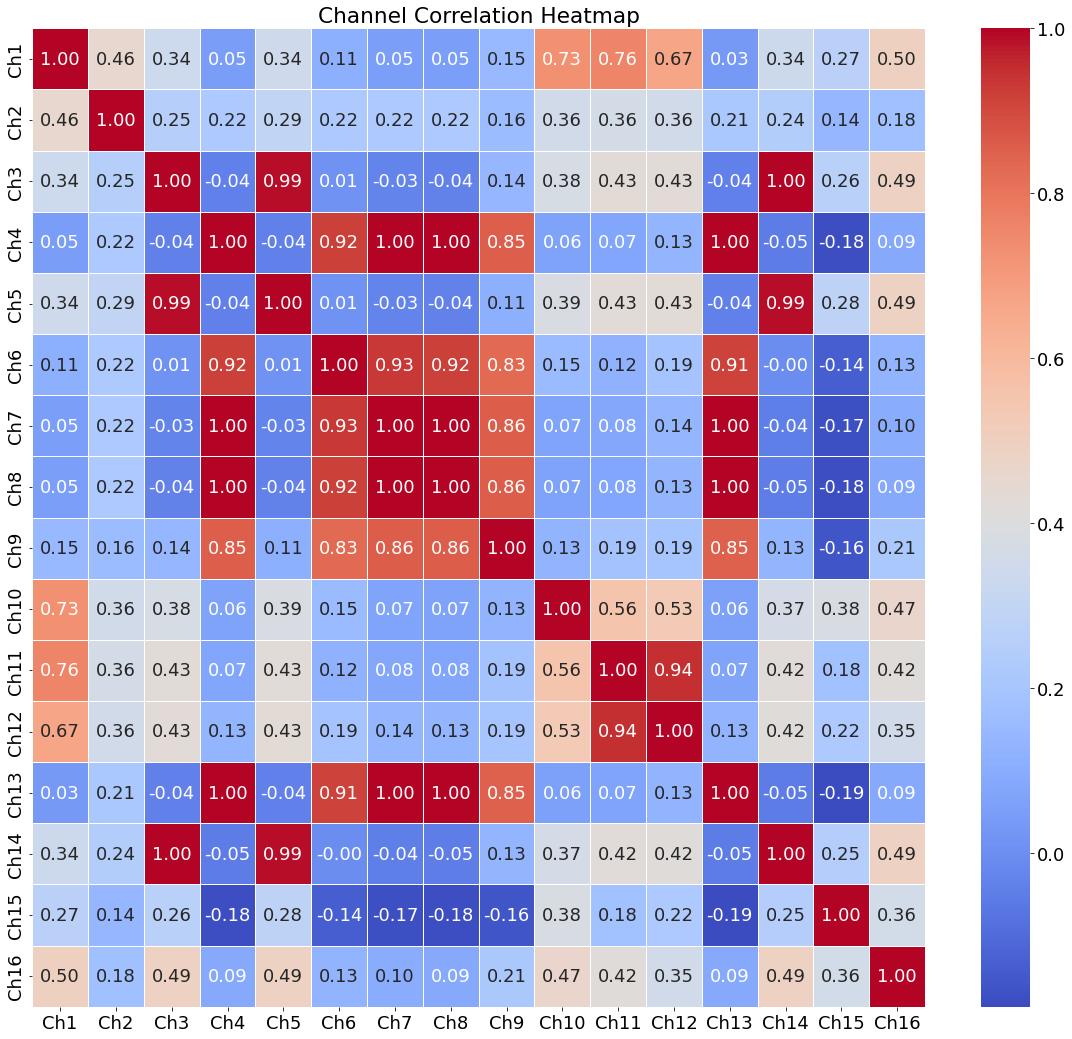

In [13]:
# データフレームに変換
df2 = pd.DataFrame({
    'Ch1': sou1,
    'Ch2': sou2,
    'Ch3': sou3,
    'Ch4': sou4,
    'Ch5': sou5,
    'Ch6': sou6,
    'Ch7': sou7,
    'Ch8': sou8,
    'Ch9': sou9,
    'Ch10': sou10,
    'Ch11': sou11,
    'Ch12': sou12,
    'Ch13': sou13,
    'Ch14': sou14,
    'Ch15': sou15,
    'Ch16': sou16,
})

#上記のままだとデータフレームの中の数値が[]で囲われているから直す
df2 = df2.astype(float)

# 相関行列を計算
correlation_matrix = df2.corr()

# ヒートマップを描画
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5) #, fmt='.2f'
plt.title('Channel Correlation Heatmap')
plt.show()


<Figure size 720x720 with 0 Axes>

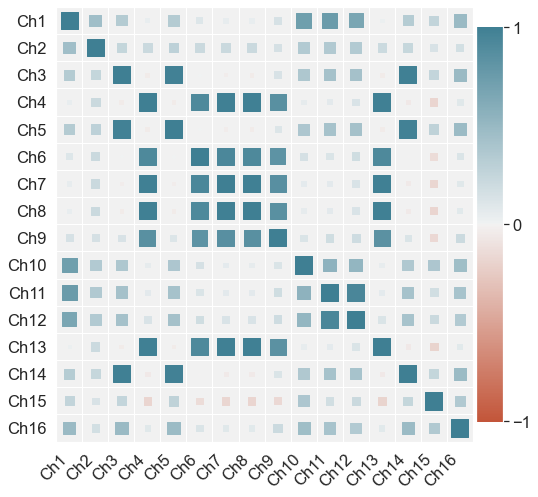

In [15]:
#参考：https://www.nemotos.net/?p=4992

from heatmap import corrplot
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from pylab import rcParams

plt.figure(figsize=(10, 10))
sns.set(color_codes=True, font_scale=1.5)

# ヒートマップの作成
plt.figure(figsize=(8, 8))
corrplot(df2.corr(), size_scale=300)


# 図の保存と表示
#plt.savefig('advanced_heatmap.png')
plt.show()

<Figure size 720x720 with 0 Axes>

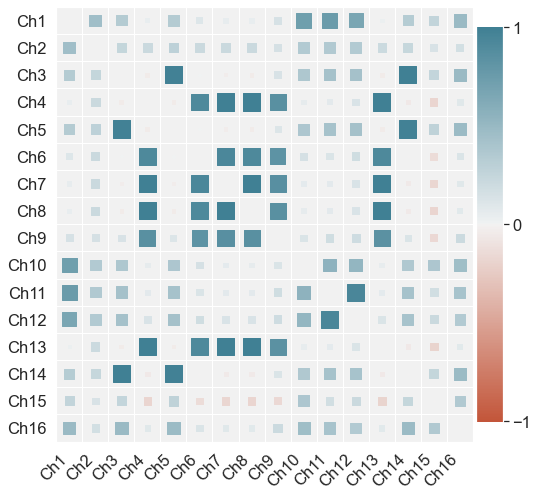

In [16]:
#対角成分0
plt.figure(figsize=(10, 10))
sns.set(color_codes=True, font_scale=1.5)

# ヒートマップの作成
plt.figure(figsize=(8, 8))
corr = df2.corr()
np.fill_diagonal(corr.values, 0)  # 対角成分を0に設定
corrplot(corr, size_scale=300)

# 図の保存と表示
#plt.savefig('advanced_heatmap.png')
plt.show()

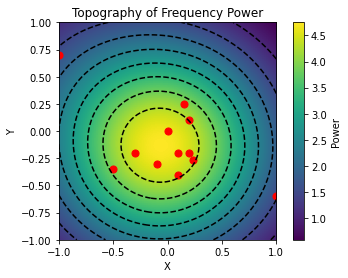

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# 電極の位置情報（仮の値、16個の電極座標）
electrode_positions = np.array([
    [0.0, 0.0],  # 電極1の座標 (x, y)
    [0.2, 0.1],  # 電極2の座標
    [0.1, -0.2], # 電極3の座標
    [0.2, -0.2],
    [-0.3, -0.2],
    [-0.1, -0.3],
    [0.1, -0.4],
    [0.15, 0.25],
    [-0.5, -0.35],
    [0.23, -0.27],
    [-1, 0.7],
    [1, -0.6],
    # ...他の電極の座標を追加
])

num_electrodes = electrode_positions.shape[0]

# ダミーの周波数パワーデータを生成する例
power_data = np.random.rand(num_electrodes)

# トポグラフィを作成するための格子を作成
grid_size = 100
x_range = np.linspace(-1, 1, grid_size)
y_range = np.linspace(-1, 1, grid_size)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# トポグラフィの値を計算
topography = np.zeros((grid_size, grid_size))
for electrode_idx in range(num_electrodes):
    electrode_x, electrode_y = electrode_positions[electrode_idx]
    distance = np.sqrt((x_grid - electrode_x)**2 + (y_grid - electrode_y)**2)
    topography += power_data[electrode_idx] * np.exp(-distance**2)

# トポグラフィを描画
plt.imshow(topography, extent=(-1, 1, -1, 1), origin='lower', cmap=cm.viridis)
plt.colorbar(label='Power')
plt.scatter(electrode_positions[:, 0], electrode_positions[:, 1], c='red', marker='o', s=50)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Topography of Frequency Power')
plt.gca().set_aspect('equal', adjustable='box')  # アスペクト比を調整


# 等高線を重ねて描画
contour_levels = np.linspace(np.min(topography), np.max(topography), 10)
plt.contour(x_grid, y_grid, topography, levels=contour_levels, colors='black', linestyles='dashed')

plt.show()